## Problem 1

In [1]:
import numpy as np
from scipy import linalg as la   

In [2]:
def condition(A):
    if min(la.svdvals(A)) == 0:
        cond = np.inf
    else:
        cond = max(la.svdvals(A))/min(la.svdvals(A))
    return cond

In [3]:
# validate the function by comparing it to np.linalg.cond()
A = np.array([[2, 3], [4, 5]])
print(condition(A))
print(np.linalg.cond(A))

26.9629120178363
26.9629120178363


In [4]:
# orthonormal matrices have a condition number of 1
Q = la.qr(A)[0]
condition(Q)

1.0000000000000002

In [5]:
#  singular matrices have a condition number of ∞
O = np.zeros([3,3])
condition(O)

inf

## Problem 2

In [6]:
import sympy as sy
from matplotlib import pyplot as plt

In [7]:
# Get the exact Wilkinson polynomial coefficients using SymPy.
w_roots = np.arange(1, 21)
x, i = sy.symbols('x i')
w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
w_coeffs = np.array(w.all_coeffs())

In [8]:
# carry out the experiment 100 times.
perturb = np.zeros([20,100],dtype=complex)
abscond = np.zeros(100)
relcond = np.zeros(100)

for i in range(100):
    # Perturb the coefficients
    r = np.random.normal(loc=1, scale=1e-10, size=21)
    new_coeffs = w_coeffs * r
    h = new_coeffs - w_coeffs
    new_roots = np.roots(np.poly1d(new_coeffs))
    perturb[:,i] = np.sort(new_roots)
    
    # Estimate the absolute condition number in the infinity norm.
    k = la.norm(new_roots - w_roots, np.inf) / la.norm(h, np.inf)
    abscond[i] = k
    
    # Estimate the relative condition number in the infinity norm.
    relcond[i] = k * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)

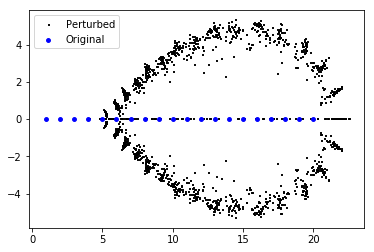

In [9]:
#  Plot the perturbed roots and original roots in the complex plane
X_perturb = [x.real for x in perturb]
Y_perturb = [x.imag for x in perturb]
X_original = [x.real for x in w_roots]
Y_original = [x.imag for x in w_roots]
plt.scatter(X_perturb,Y_perturb, color='k',s=1,marker=',',label='Perturbed')
plt.scatter(X_original,Y_original, color='b',s=15,marker='o',label='Original')
plt.legend()
plt.show()

In [10]:
np.mean(abscond)

1.4433737666406033e-08

In [11]:
np.mean(relcond)

9961992354.707176

## Problem 3

In [12]:
def compcond(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    Atilde = A + H
    kappahat = la.norm(la.eigvals(Atilde) - la.eigvals(A))/la.norm(H)
    kappa = kappahat*la.norm(A)/la.norm(la.eigvals(A))
    return kappahat, kappa

## Problem 4

In [13]:
def plotcond(xmin,xmax,ymin,ymax,res):
    x = np.linspace(xmin,xmax,res)
    y = np.linspace(ymin,ymax,res)
    relcond = np.zeros((res,res))
    for indx, xx in enumerate(x):
        for indy, yy in enumerate(y):
            A = np.array([[1,xx],[yy,1]])
            relcond[indx,indy] = compcond(A)[1]
    
    X,Y = np.meshgrid(x,y)
    plt.pcolormesh(X,Y,relcond,cmap='gray_r')
    plt.colorbar()
    plt.show()

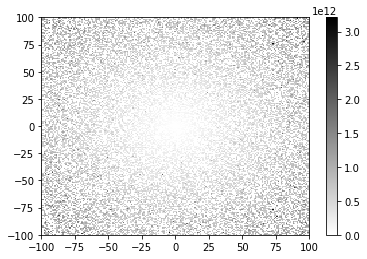

In [14]:
plotcond(-100,100,-100,100,200)

## Problem 5

In [15]:
def polynomial_approximate(n):
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n+1)
    
    # first approach: inverse
    x_inv = la.inv(A.T @ A) @ A.T @ yk
    
    # second approach: QR decomposition
    Q, R = la.qr(A, mode='economic')
    x_qr = la.solve_triangular(R,Q.T @ yk)
    
    # forward errors
    fe_inv = la.norm(A @ x_inv - yk)
    fe_qr = la.norm(A @ x_qr - yk)
    
    # plotting the resulting polynomials  
    xaxis = np.linspace(0, 1, 100)
    y_inv = np.polyval(x_inv, xaxis)
    y_qr = np.polyval(x_qr, xaxis)
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    plt.scatter(xk, yk, label='Data', s=1, marker='*')
    plt.plot(xaxis, y_inv, 'b', label='Normal Equations')
    plt.plot(xaxis, y_qr, 'orange', label='QR Solver')
    plt.legend()
    plt.show()
    
    return fe_inv, fe_qr

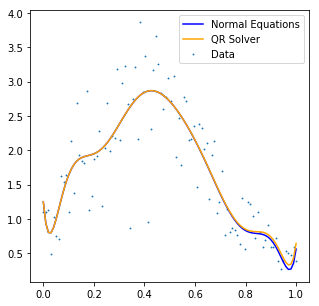

(4.649618797079317, 4.644309587536279)

In [16]:
polynomial_approximate(10)

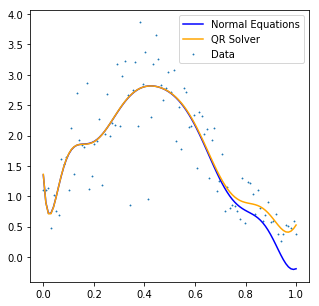

(4.973558668305269, 4.622026000831605)

In [17]:
polynomial_approximate(11)

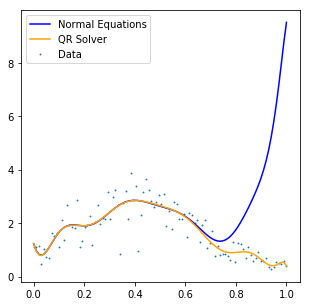

(21.105759497913752, 4.593408026825677)

In [18]:
polynomial_approximate(12)

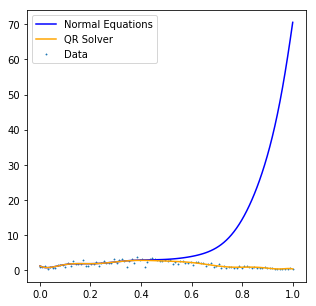

(182.47535246459793, 4.5933895239657)

In [19]:
polynomial_approximate(13)

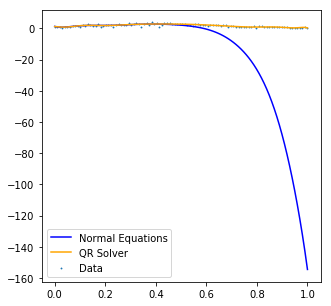

(396.94219827796326, 4.5683709512230175)

In [20]:
polynomial_approximate(14)

## Problem 6

In [21]:
import sympy as sy

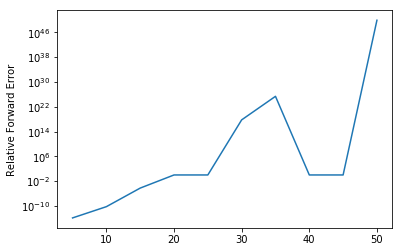

In [22]:
x = sy.Symbol('x')
rfe = []

for n in np.arange(5,51,5):
    # make sure that the values of n are actual integers, not floats
    n = int(n)
    sybintegral = float(sy.integrate(x**n*sy.exp(x-1),(x,0,1)))
    comintegral = float((-1)**n*sy.subfactorial(n) + (-1)**(n+1)*sy.factorial(n)/np.e)
    error = abs(sybintegral - comintegral) / abs(sybintegral)
    rfe.append(error) 

plt.plot(np.arange(5, 51, 5), rfe)
plt.yscale('log')
plt.ylabel('Relative Forward Error')
plt.show()